In [1]:
#training deep neural networks on gpu if you have a gpu but if you dont then on cpu

In [2]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torchvision.datasets import MNIST, FakeData
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
#download dataset, but i already have it downloaded
dataset = MNIST(root='data/', train=True, transform=ToTensor())


In [4]:
#validation set

def split_indices(n, val_pct):
    pct_gone = int(n*val_pct)
    print(pct_gone)
    idxs = np.random.permutation(n)
    #so from 12,000 images to the end - we set the training dataset to those random permutations
    return idxs[pct_gone:], idxs[:pct_gone]

In [5]:
train_indices, val_indices = split_indices(len(dataset), 0.2)

12000


In [6]:
img, label = dataset[0]

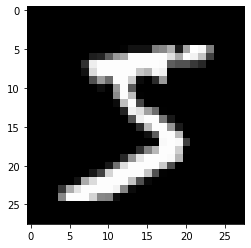

In [7]:
plt.imshow(img[0], cmap='gray')

In [8]:
#we will randomize the position of the data, in order to lessen the biases
#we will create batches out of the indices that are specified below
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, 100, sampler=train_sampler)

In [9]:
#we will create batches out of the indices that are specified below
#it will do a random shuffle opf the data, gradient descent works better when you randomize the data

#we need a validation set to test the model on data that it hasn't seen, and then you can tweak the hyperparams
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, 100, sampler=val_sampler)

In [10]:
#nn.Linear takes inputs and outputs, creates weights and biases, bases of linear and logistic regression
#you need to flatten it out to a vector of size 784
#the outputs are the probabilites of the numbers being the correct prediction

In [11]:
#Now, in the deep learning neural network we are creating: 
    #we will use 2 nn.Linear objects. Each one acts as a hidden layer inside the model
    #the first layer, nn.Linear, wil transform the input matrix, which has already been reshaped to batch * 784
        #to now it will be batch * hidden_size, which hidden_size is a preconfigured parameter, like 32 or 64
        
    #the intermediate outputs of the layer are passed on to the activation function, which operates on individual
    #elements of the output vector
    
    #The result of the activation function is then passed on to the second layer:
        #The second layer transforms the output into batch_size * 10, identical to the logistic regression model
        
#differences between this and logistic regression:
    #logistic regression model takes in an image, and uses something called cross_entropy to caclulate the loss
    #which is then put back into the model in order to optimize the function. The forward function, which is re
    #-sponsible for outputting the alterations it does to the inputs in order for the data to be used to calc-
    #-ulate the gradients, reshapes the data into -1,784 (-1 is kinda a placeholder), and then it returns the 
    #nn.linear model with the correct input and output layer
    #cross entropy does its own softmax in order to convert it into probabilities
    

    #just like how linear regression and logistic regression are similar, because logistic regression is predic-
    #-ting the probability of a certain item being the correct answer 
    
    
    #input layer -> hidden layer (activation function) => output layer (10) -> probabilities -> output
    
    #brings non-linearity into the model - 
    
    
    #activation function = ReLu relu(x) = max(0,x) -> if element is negative - leave it as zero, leave the real
    #number


In [50]:
#as you can see, if the value is less than 0, it gets set to 0 - Relu at work
# x = torch.Tensor([0,-1,-1])
# F.relu(x)
#batch size should be as large as possible, without making the training slow
#but should also be depending on one's gpu/cpu
#start at 32/64 and doubling until it doesnt help anymore
#the model was getting confused because the pixels that were getting activated, so the relu is giving it the abi
#ility to do a non-linearity
#view vs reshape -> view ensures the use of the same block of memory
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out=self.linear2(out)
        return out


In [51]:
#to lose the sense of linearity we do the relu in order to make sure the accuracy is better than 80%
input_size = 28**2
hidden_size = 32
num_classes = 10

model = MnistModel(input_size, hidden_size, num_classes)

for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [58]:
for img, lbl in train_loader:
    out = model(img)
    loss = F.cross_entropy(out, lbl)
    print(loss.item())
    break

2.3012804985046387


In [60]:
#gpus are very suited for games - which do a lot of matrix multiplication

In [ ]:
# I will write the code here and train the model on google colab

In [185]:
#For reference, i will put a logistic regression example here:

#It is all commented out so you could see how one would implement it. It is similar isn't it

In [186]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, xb):
        #whenever you are inputting data into the model, we need to reshape it
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

In [187]:

other_model = MnistModel()

#inital loss

# for xb, yb in train_loader:
#     preds = model(xb)
#     loss = F.cross_entropy(preds, yb)

In [188]:
#xb is the pixel densities as a tenso, and yb are the labels, we will calc the loss on the yb and the xb
def loss_batch(loss_fn, model, xb, yb, opt):
    outputs = model(xb)
    loss = loss_fn(outputs, yb)
#     print(loss)
    loss.backward()
    opt.step()
    opt.zero_grad()

In [189]:
def train(epochs, loss_fn, model, train_loader, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr)
    for epoch in range(epochs):
        for xb, yb in train_loader:
            loss_batch(loss_fn, model, xb, yb, optimizer)
        

In [190]:
train(5, F.cross_entropy, other_model, train_loader, 1e-3)

In [191]:
arr_acc = []

def test_validate_set(model,loss_fn, valid_dl):
    for xbv, ybv in valid_dl:
        outputs = model(xbv)
        loss = loss_fn(outputs, ybv)
        print(loss)
        probs,preds = torch.max(outputs, dim=1)
        for i in range(len(preds)):
            if(preds[i].item() != ybv[i].item()):
                arr_acc.append(0)
            else:
                arr_acc.append(1)
        

In [ ]:
test_validate_set(other_model,F.cross_entropy, val_loader)
print(sum(arr_acc) / len(arr_acc))

In [172]:
test_dataset = MNIST(root = 'data/', train = False, transform = ToTensor())
def predict_image(img, model):
    output = model(img)
    prob, preds = torch.max(output, dim = 1 )
    print(preds[0].item())


In [173]:
x = 10
img, labels = test_dataset[x]
predict_image(img, other_model)
print(labels)


0
0


In [193]:
#done with the logistic testing

In [194]:
#time for deeeeeeep